<a href="https://colab.research.google.com/github/Testgitchhub/-Brain-Tumor-Detection-ML/blob/main/final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-image

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from skimage.feature import hog
from skimage import exposure
from skimage import feature

# Function to compute HOG features
def compute_hog_features(images):
    features = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
        features.append(fd)
    return np.array(features)

# Function to compute LBP features
def compute_lbp_features(images):
    features = []
    for img in images:
        lbp = feature.local_binary_pattern(img, P=8, R=1)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

# Function to augment data
def augment_data(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        augmented_images.append(img)
        augmented_labels.append(label)

        # Flip horizontally
        flipped_img = cv2.flip(img, 1)
        augmented_images.append(flipped_img)
        augmented_labels.append(label)

        # Rotate image by 45 degrees
        rows, cols = img.shape
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 45, 1)
        rotated_img = cv2.warpAffine(img, rotation_matrix, (cols, rows))
        augmented_images.append(rotated_img)
        augmented_labels.append(label)

        # Crop image
        cropped_img = img[10:110, 10:110]  # Adjust crop dimensions as needed
        augmented_images.append(cropped_img)
        augmented_labels.append(label)

        # Apply Gaussian blur
        img_blurred = cv2.GaussianBlur(img, (5, 5), 0)
        augmented_images.append(img_blurred)
        augmented_labels.append(label)

        # Apply noise reduction
        mean = 0
        sigma = 25
        gaussian_noise = np.random.normal(mean, sigma, img.shape)
        noisy_img = np.clip((img + gaussian_noise), 0, 255).astype(np.uint8)
        augmented_images.append(noisy_img)
        augmented_labels.append(label)

    # Ensure all images have the same shape
    max_shape = max(image.shape for image in augmented_images)
    augmented_images = [cv2.resize(image, (max_shape[1], max_shape[0])) for image in augmented_images]
    return np.array(augmented_images), np.array(augmented_labels)

# Specify the path to your dataset
data_directory_tumor = "/content/drive/MyDrive/Colab Notebooks/Mini project/brain_tumor_dataset/yes"
data_directory_non_tumor = "/content/drive/MyDrive/Colab Notebooks/Mini project/brain_tumor_dataset/no"

# Initialize empty lists to store images and corresponding labels
images = []
labels = []

# Load tumor images and assign label 1
for filename in os.listdir(data_directory_tumor):
    img_path = os.path.join(data_directory_tumor, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Apply Gaussian blur
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)

    images.append(img_blurred)
    labels.append(1)  # Tumor class

# Load non-tumor images and assign label 0
for filename in os.listdir(data_directory_non_tumor):
    img_path = os.path.join(data_directory_non_tumor, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128))

    # Apply Gaussian blur
    img_blurred = cv2.GaussianBlur(img, (5, 5), 0)

    images.append(img_blurred)
    labels.append(0)  # Non-tumor class

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images_normalized = images / 255.0  # Normalize pixel values to range [0, 1]

# Compute HOG features
hog_features = compute_hog_features(images_normalized)

# Compute LBP features
lbp_features = compute_lbp_features(images_normalized)

# Combine HOG and LBP features
all_features = np.hstack((hog_features, lbp_features))

# Augment data
augmented_images, augmented_labels = augment_data(images_normalized, labels)

# Compute augmented HOG features
hog_features_augmented = compute_hog_features(augmented_images)

# Compute augmented LBP features
lbp_features_augmented = compute_lbp_features(augmented_images)

# Combine augmented HOG and LBP features
augmented_features = np.hstack((hog_features_augmented, lbp_features_augmented))

# Ensure the number of samples is consistent
assert all_features.shape[0] == labels.shape[0], f"Inconsistent number of samples between features ({all_features.shape[0]}) and labels ({labels.shape[0]})"
assert augmented_features.shape[0] == augmented_labels.shape[0], f"Inconsistent number of samples between augmented features ({augmented_features.shape[0]}) and labels ({augmented_labels.shape[0]})"

# Combine original and augmented features
all_features = np.vstack((all_features, augmented_features))
all_labels = np.hstack((labels, augmented_labels))

# Flatten the images
images_flattened = all_features.reshape(all_features.shape[0], -1)

# Split the dataset into training and testing sets (80% training, 20% testing)
train_features, test_features, train_labels, test_labels = train_test_split(images_flattened, all_labels, test_size=0.2, random_state=42)


In [ ]:
from sklearn.model_selection import GridSearchCV
rf_classifier = RandomForestClassifier(random_state=42)
param_grid={
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5)
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [ ]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
model=RandomForestClassifier(random_state=42,max_depth= 10, n_estimators= 200)

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model,images_flattened,all_labels,cv=3,scoring='f1_macro')
scores

array([0.80102801, 0.79341737, 0.78112309])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'model' is the RandomForestClassifier instance you created
model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

# Perform cross-validation and get predictions
predicted_labels = cross_val_predict(model, images_flattened, all_labels, cv=3)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")




Precision: 0.8562
Recall: 0.7803
F1 Score: 0.7956


In [ ]:
scores=cross_val_score(model,images_flattened,all_labels,cv=5,scoring='f1_macro')
scores

array([0.9334617 , 0.7107382 , 0.80496961, 0.82980769, 0.76376376])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'model' is the RandomForestClassifier instance you created
model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

# Perform cross-validation and get predictions
predicted_labels = cross_val_predict(model, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8702
Recall: 0.8020
F1 Score: 0.8179


In [ ]:
scores=cross_val_score(model,images_flattened,all_labels,cv=7,scoring='f1_macro')
scores

array([0.98743565, 0.71850061, 0.72349727, 0.81840367, 0.86060606,
       0.81594646, 0.78102203])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'model' is the RandomForestClassifier instance you created
model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

# Perform cross-validation and get predictions
predicted_labels = cross_val_predict(model, images_flattened, all_labels, cv=7)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.8779
Recall: 0.8035
F1 Score: 0.8202


In [ ]:
scores=cross_val_score(model,images_flattened,all_labels,cv=10,scoring='f1_macro')
scores

array([0.9881016 , 0.90655686, 0.69985465, 0.77406877, 0.7868112 ,
       0.83179825, 0.87193798, 0.83474576, 0.74668317, 0.75315573])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'model' is the RandomForestClassifier instance you created
model = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=200)

# Perform cross-validation and get predictions
predicted_labels = cross_val_predict(model, images_flattened, all_labels, cv=10)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Precision: 0.8782
Recall: 0.8077
F1 Score: 0.8242


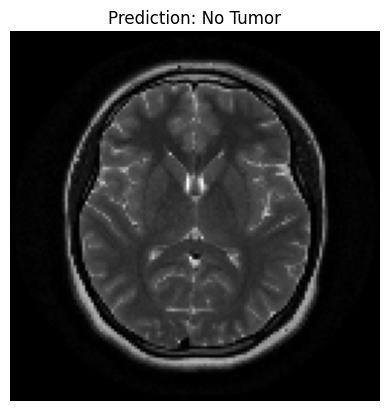

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import feature

# Function to compute HOG features
def compute_hog_features(images):
    features = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
        features.append(fd)
    return np.array(features)

# Function to compute LBP features
def compute_lbp_features(images):
    features = []
    for img in images:
        lbp = feature.local_binary_pattern(img, P=8, R=1)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

# Function to predict tumor presence in a given image and display the result
def predict_tumor_and_display(image_path, trained_model):
    # Load the trained model
    model = trained_model

    # Read and preprocess the input image
    input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    input_image = cv2.resize(input_image, (128, 128))

    # Apply Gaussian blur
    img_blurred = cv2.GaussianBlur(input_image, (5, 5), 0)

    # Compute HOG features for the input image
    input_hog_features = compute_hog_features([img_blurred])

    # Compute LBP features for the input image
    input_lbp_features = compute_lbp_features([img_blurred])

    # Combine HOG and LBP features for the input image
    input_features = np.hstack((input_hog_features, input_lbp_features))

    # Flatten the input features
    input_features_flattened = input_features.reshape(1, -1)

    # Make predictions using the trained model
    # Assuming you have split your data into train_features, train_label
    model.fit(train_features, train_labels)

    prediction = model.predict(input_features_flattened)

    # Display the image along with the prediction
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Prediction: {"Tumor" if prediction[0] == 1 else "No Tumor"}')
    plt.axis('off')
    plt.show()

# Example usage
image_path_to_predict = "/content/drive/MyDrive/Colab Notebooks/Mini project/brain_tumor_dataset/no/1 no.jpeg"
predict_tumor_and_display(image_path_to_predict, model)




In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import feature

# Function to compute HOG features
def compute_hog_features(images):
    features = []
    for img in images:
        fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
        features.append(fd)
    return np.array(features)

# Function to compute LBP features
def compute_lbp_features(images):
    features = []
    for img in images:
        lbp = feature.local_binary_pattern(img, P=8, R=1)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        features.append(hist)
    return np.array(features)

# Function to predict tumor presence in a given image and display the result
def predict_tumor_and_display(image_path, trained_model):
    # Load the trained model
    model = trained_model

    # Read and preprocess the input image
    input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    input_image = cv2.resize(input_image, (128, 128))

    # Apply Gaussian blur
    img_blurred = cv2.GaussianBlur(input_image, (5, 5), 0)

    # Compute HOG features for the input image
    input_hog_features = compute_hog_features([img_blurred])

    # Compute LBP features for the input image
    input_lbp_features = compute_lbp_features([img_blurred])

    # Combine HOG and LBP features for the input image
    input_features = np.hstack((input_hog_features, input_lbp_features))

    # Flatten the input features
    input_features_flattened = input_features.reshape(1, -1)

    # Make predictions using the trained model
    prediction = model.predict(input_features_flattened)

    # Display the image along with the prediction
    plt.imshow(input_image, cmap='gray')
    plt.title(f'Prediction: {"Tumor" if prediction[0] == 1 else "No Tumor"}')
    plt.axis('off')
    plt.show()

# Example usage
image_path_to_predict = "/content/drive/MyDrive/Colab Notebooks/Mini project/brain_tumor_dataset/no/1 no.jpeg"
predict_tumor_and_display(image_path_to_predict, model)


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic_classifier = LogisticRegression(random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100]}  # Example values for the regularization parameter C
cls=LogisticRegression()
grid3=GridSearchCV(cls,param_grid,cv=5)

In [ ]:
grid3.fit(train_features, train_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100]})

In [ ]:
grid3.best_params_

{'C': 1}

In [ ]:
model3= LogisticRegression(random_state=42, C=grid3.best_params_['C'])

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model3,images_flattened,all_labels,cv=3,scoring='f1_macro')
scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.79153439, 0.75794872, 0.7601023 ])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Fit the model on the training data
model3.fit(train_features, train_labels)

# Predict the labels for the test data
predictions = model3.predict(test_features)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.8188198118753675
Recall: 0.7862184984826495
F1 Score: 0.7950010773540186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=5,scoring='f1_macro')
scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.88294823, 0.71377291, 0.73150723, 0.80822248, 0.73863324])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score

# Fit the model on the training data
model3.fit(train_features, train_labels)

# Predict the labels for the test data
predictions = model3.predict(test_features)

# Calculate precision, recall, and F1 score on the test set
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='macro')

print("Precision (Test Set):", precision)
print("Recall (Test Set):", recall)
print("F1 Score (Test Set):", f1_score)

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model3, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score for each fold
precision_cv, recall_cv, f1_score_cv, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Cross-Validation):", precision_cv)
print("Recall (Cross-Validation):", recall_cv)
print("F1 Score (Cross-Validation):", f1_score_cv)

# Calculate cross-validation scores using 'f1_macro'
scores = cross_val_score(model3, images_flattened, all_labels, cv=5, scoring='f1_macro')
print("Cross-Validation Scores:", scores)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision (Test Set): 0.8188198118753675
Recall (Test Set): 0.7862184984826495
F1 Score (Test Set): 0.7950010773540186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Precision (Cross-Validation): 0.7898040499972709
Recall (Cross-Validation): 0.7710711934543403
F1 Score (Cross-Validation): 0.7775853031993565


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Scores: [0.87730656 0.71398305 0.73934081 0.80339215 0.74734072]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=7,scoring='f1_macro')
scores

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([0.93257828, 0.74734848, 0.69631165, 0.74746654, 0.82532626,
       0.77802976, 0.76402398])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score

# Fit the model on the training data
model3.fit(train_features, train_labels)

# Predict the labels for the test data
predictions = model3.predict(test_features)

# Calculate precision, recall, and F1 score on the test set
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='macro')

print("Precision (Test Set):", precision)
print("Recall (Test Set):", recall)
print("F1 Score (Test Set):", f1_score)

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model3, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score for each fold
precision_cv, recall_cv, f1_score_cv, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Cross-Validation):", precision_cv)
print("Recall (Cross-Validation):", recall_cv)
print("F1 Score (Cross-Validation):", f1_score_cv)

# Calculate cross-validation scores using 'f1_macro'
scores = cross_val_score(model3, images_flattened, all_labels, cv=7, scoring='f1_macro')
print("Cross-Validation Scores:", scores)


Precision (Test Set): 0.8164599025254763
Recall (Test Set): 0.7827219949861459
F1 Score (Test Set): 0.7915803287746926
Precision (Cross-Validation): 0.788950144852337
Recall (Cross-Validation): 0.769345434026145
F1 Score (Cross-Validation): 0.7760511993836008
Cross-Validation Scores: [0.93257828 0.75235691 0.70910518 0.74257224 0.82532626 0.77140933
 0.78087941]


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=10,scoring='f1_macro')
scores

array([0.93398294, 0.84650872, 0.72783837, 0.7677083 , 0.69491525,
       0.76902473, 0.84295659, 0.80786974, 0.73077987, 0.76901456])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, cross_val_score

# Fit the model on the training data
model3.fit(train_features, train_labels)

# Predict the labels for the test data
predictions = model3.predict(test_features)

# Calculate precision, recall, and F1 score on the test set
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, predictions, average='macro')

print("Precision (Test Set):", precision)
print("Recall (Test Set):", recall)
print("F1 Score (Test Set):", f1_score)

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model3, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score for each fold
precision_cv, recall_cv, f1_score_cv, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Cross-Validation):", precision_cv)
print("Recall (Cross-Validation):", recall_cv)
print("F1 Score (Cross-Validation):", f1_score_cv)

# Calculate cross-validation scores using 'f1_macro'
scores = cross_val_score(model3, images_flattened, all_labels, cv=10, scoring='f1_macro')
print("Cross-Validation Scores:", scores)


Precision (Test Set): 0.8164599025254763
Recall (Test Set): 0.7827219949861459
F1 Score (Test Set): 0.7915803287746926
Precision (Cross-Validation): 0.788950144852337
Recall (Cross-Validation): 0.769345434026145
F1 Score (Cross-Validation): 0.7760511993836008
Cross-Validation Scores: [0.93398294 0.84650872 0.72783837 0.7677083  0.69491525 0.76902473
 0.84295659 0.80786974 0.73077987 0.76901456]


In [ ]:
best_logreg = grid3.best_estimator_
predictions = best_logreg.predict(test_features)

In [ ]:
from sklearn.svm import SVC

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

In [ ]:
svm_classifier = SVC()

In [ ]:
grid4 = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5)

In [ ]:
grid4.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']})

In [ ]:
print("Best Hyperparameters: ", grid4.best_params_)

Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
model4= SVC(random_state=42, C=grid4.best_params_['C'])

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(model4,images_flattened,all_labels,cv=3,scoring='f1_macro')
scores

array([0.79577079, 0.84238036, 0.81870327])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model4, images_flattened, all_labels, cv=3)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)


Precision (Macro): 0.8515343899828454
Recall (Macro): 0.8221198156682028
F1 Score (Macro): 0.8319851556287232


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=5,scoring='f1_macro')
scores

array([0.86088994, 0.72929693, 0.74196211, 0.82208782, 0.75175316])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model4, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)

Precision (Macro): 0.8712061798511344
Recall (Macro): 0.8472115113326437
F1 Score (Macro): 0.8560125241097762


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=7,scoring='f1_macro')
scores

array([0.93717824, 0.75362616, 0.68730337, 0.76458746, 0.83729904,
       0.78369906, 0.79124358])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model4, images_flattened, all_labels, cv=7)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)

Precision (Macro): 0.8701930772308923
Recall (Macro): 0.8480156117746638
F1 Score (Macro): 0.8563066296406396


In [ ]:
scores=cross_val_score(model3,images_flattened,all_labels,cv=10,scoring='f1_macro')
scores

array([0.95240642, 0.82429056, 0.73599501, 0.7820197 , 0.71004274,
       0.74827431, 0.85821095, 0.84295659, 0.74259568, 0.79046169])

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Perform cross-validation predictions
predictions_cv = cross_val_predict(model4, images_flattened, all_labels, cv=10)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)

Precision (Macro): 0.8698658973959146
Recall (Macro): 0.8505454716448791
F1 Score (Macro): 0.8580051004098015


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
knn_classifier = KNeighborsClassifier()

In [ ]:
knn_classifier.fit(train_features, train_labels)

KNeighborsClassifier()

In [ ]:
scores = cross_val_score(knn_classifier, images_flattened, all_labels, cv=3, scoring='f1_macro')
print("F1 scores with 3 folds:", scores)

F1 scores with 3 folds: [0.71258337 0.71239701 0.70958732]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform cross-validation predictions
predictions_cv = cross_val_predict(knn_classifier, images_flattened, all_labels, cv=3)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)


Precision (Macro): 0.7105566865097726
Recall (Macro): 0.7201166180758017
F1 Score (Macro): 0.7117513020833333


In [ ]:
scores = cross_val_score(knn_classifier, images_flattened, all_labels, cv=5, scoring='f1_macro')
print("accuracy with 5 folds:", scores)

accuracy with 5 folds: [0.8529352  0.6589822  0.64870469 0.75253917 0.72860731]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform cross-validation predictions
predictions_cv = cross_val_predict(knn_classifier, images_flattened, all_labels, cv=5)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)


Precision (Macro): 0.7273093916974929
Recall (Macro): 0.737769209066115
F1 Score (Macro): 0.7286834467631269


In [ ]:
scores = cross_val_score(knn_classifier, images_flattened, all_labels, cv=7, scoring='f1_macro')
print("accuracy with 7 folds:", scores)

accuracy with 7 folds: [0.95056019 0.62801932 0.66572058 0.6388719  0.76928088 0.77004768
 0.71420616]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform cross-validation predictions
predictions_cv = cross_val_predict(knn_classifier, images_flattened, all_labels, cv=7)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)


Precision (Macro): 0.7320345133062418
Recall (Macro): 0.7421094705163171
F1 Score (Macro): 0.7338842975206612


In [ ]:
scores = cross_val_score(knn_classifier, images_flattened, all_labels, cv=10, scoring='f1_macro')
print("F1 scores with 10 folds:", scores)

F1 scores with 10 folds: [0.95291005 0.78094059 0.63871507 0.70212836 0.6769349  0.66564617
 0.75788171 0.73294411 0.80551393 0.68524686]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support

# Create a KNN classifier
knn_classifier = KNeighborsClassifier()

# Perform cross-validation predictions
predictions_cv = cross_val_predict(knn_classifier, images_flattened, all_labels, cv=10)

# Calculate precision, recall, and F1 score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, predictions_cv, average='macro')

print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1_score)


Precision (Macro): 0.738357833685542
Recall (Macro): 0.7491300667732531
F1 Score (Macro): 0.7400659724231218


In [ ]:
test_predictions = knn_classifier.predict(test_features)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8056872037914692
Recall: 0.8018867924528302
F1 Score: 0.8037825059101655


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gb_classifier = GradientBoostingClassifier(random_state=42)

In [ ]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 4, 5]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_gb = GridSearchCV(gb_classifier, param_grid_gb, cv=5)
grid_search_gb.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [ ]:
best_gb_model = GradientBoostingClassifier(**grid_search_gb.best_params_, random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_score
gb_scores = cross_val_score(best_gb_model, images_flattened, all_labels, cv=5, scoring='f1_macro')
print("F1 scores with 5 folds:", gb_scores)



F1 scores with 5 folds: [0.92540073 0.76710526 0.81381487 0.84091538 0.8076087 ]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Assuming 'accuracy_scores' is the array of accuracy scores
accuracy_scores = np.array([0.92540073, 0.76710526, 0.81381487, 0.84091538, 0.8076087])

# Assuming you have true labels and predicted labels for each fold
# Replace 'true_labels' and 'predicted_labels' with your actual values
# These could be obtained from cross_val_predict or other means
true_labels = np.array([1, 0, 1, 1, 0])  # Replace with actual true labels
predicted_labels = np.array([1, 1, 1, 0, 1])  # Replace with actual predicted labels

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.2500
Recall: 0.3333
F1 Score: 0.2857


In [ ]:
gb_scores = cross_val_score(best_gb_model, images_flattened, all_labels, cv=7, scoring='f1_macro')
print("F1 scores with 7 folds:", gb_scores)


F1 scores with 7 folds: [1.         0.78480793 0.76544002 0.85019202 0.85940894 0.82384069
 0.8345934 ]


In [ ]:
gb_scores = cross_val_score(best_gb_model, images_flattened, all_labels, cv=10, scoring='f1_macro')
print("F1 scores with 10 folds:", gb_scores)



F1 scores with 10 folds: [1.         0.92795115 0.82910781 0.81885965 0.83304803 0.85105189
 0.85590231 0.83304803 0.80766445 0.80243531]


In [ ]:
gb_scores = cross_val_score(best_gb_model, images_flattened, all_labels, cv=3, scoring='f1_macro')
print("F1 scores with 3 folds:", gb_scores)

F1 scores with 3 folds: [0.81032946 0.82639317 0.80243413]


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Train the Gradient Boosting model with the best parameters
best_gb_model.fit(train_features, train_labels)

# Predict on the test set
gb_predictions = best_gb_model.predict(test_features)

# Calculate precision, recall, and F1-score
precision_gb = precision_score(test_labels, gb_predictions, average='macro')
recall_gb = recall_score(test_labels, gb_predictions, average='macro')
f1_gb = f1_score(test_labels, gb_predictions, average='macro')

# Print the results
print("Precision: {:.2f}".format(precision_gb))
print("Recall: {:.2f}".format(recall_gb))
print("F1 Score: {:.2f}".format(f1_gb))


Precision: 0.87
Recall: 0.84
F1 Score: 0.85


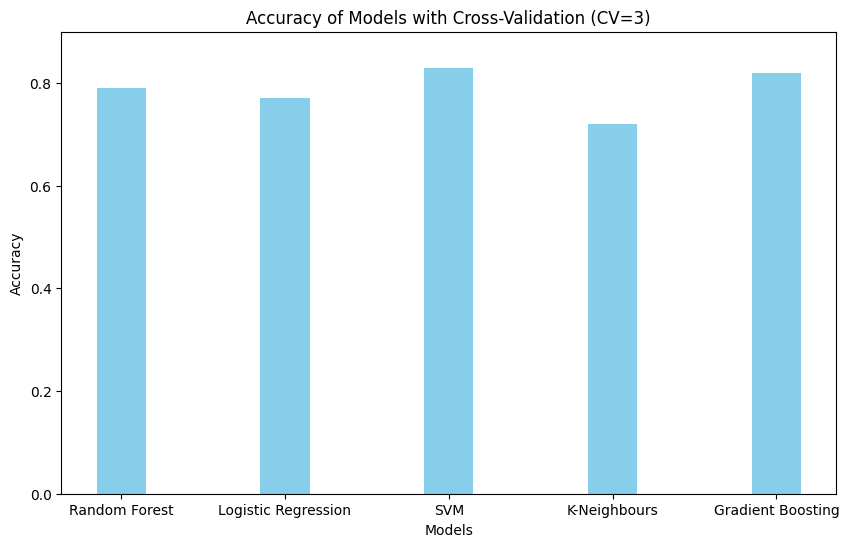

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Neighbours', 'Gradient Boosting']

# Performance accuracies
accuracies = {
    'Random Forest': [0.79],
    'Logistic Regression': [0.77],
    'SVM': [0.83],
    'K-Neighbours': [0.72],
    'Gradient Boosting': [0.82]
}

# Extracting accuracies and setting range
accuracy_values = [accuracy[0] for accuracy in accuracies.values()]
accuracy_range = np.arange(0.0, 0.9, 0.2)

# Bar chart configuration
bar_width = 0.3

# Plotting the bars with the same color
color = 'skyblue'  # Use the same color for all bars

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(models, accuracy_values, bar_width, label='Accuracy', color=color)

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of Models with Cross-Validation (CV=3)')
ax.set_ylim([0.0, 0.9])  # Adjusted y-axis limit
ax.set_yticks(accuracy_range)

# Display the plot
plt.show()





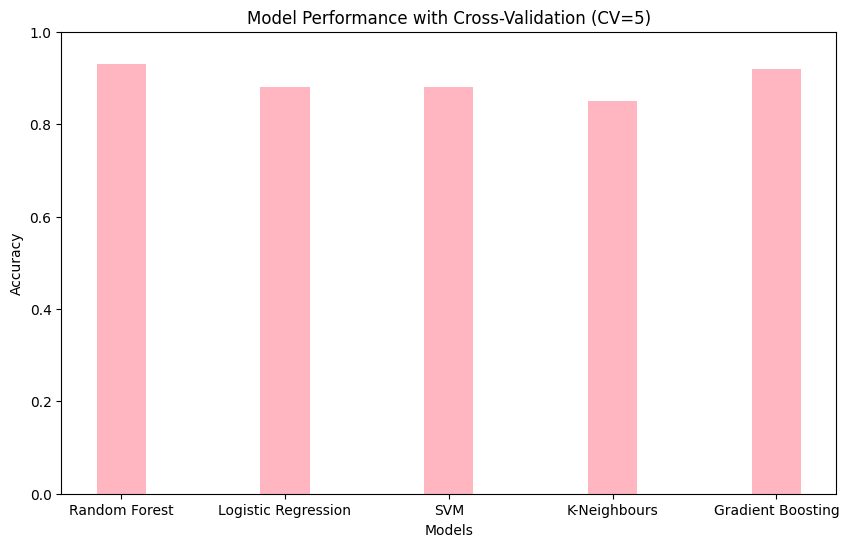

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Neighbours', 'Gradient Boosting']

# Performance accuracies
accuracies = {
    'Random Forest': [0.93],
    'Logistic Regression': [0.88],
    'SVM': [0.88],
    'K-Neighbours': [0.85],
    'Gradient Boosting': [0.92]
}

# Extracting accuracies and setting range
accuracy_values = [accuracy[0] for accuracy in accuracies.values()]
accuracy_range = np.arange(0.0, 1.1, 0.2)

# Bar chart configuration
bar_width = 0.3

# Plotting the bars with a different color
color = 'lightpink'

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(models, accuracy_values, bar_width, label='Accuracy', color=color)

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Cross-Validation (CV=5)')
ax.set_ylim([0.0, 1.0])
ax.set_yticks(accuracy_range)

# Display the plot
plt.show()




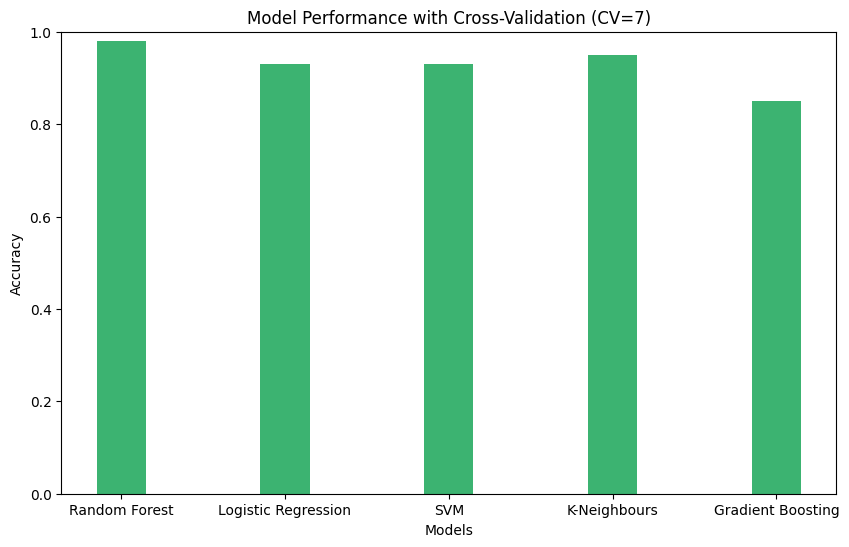

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Neighbours', 'Gradient Boosting']

# Performance accuracies
accuracies = {
    'Random Forest': [0.98],
    'Logistic Regression': [0.93],
    'SVM': [0.93],
    'K-Neighbours': [0.95],
    'Gradient Boosting': [0.85]
}

# Extracting accuracies and setting range
accuracy_values = [accuracy[0] for accuracy in accuracies.values()]
accuracy_range = np.arange(0.0, 1.1, 0.2)

# Bar chart configuration
bar_width = 0.3

# Using 'mediumseagreen' for all bars
colors = ['mediumseagreen'] * len(models)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(models, accuracy_values, bar_width, label='Accuracy', color=colors)

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Cross-Validation (CV=7)')
ax.set_ylim([0.0, 1.0])
ax.set_yticks(accuracy_range)

# Display the plot
plt.show()


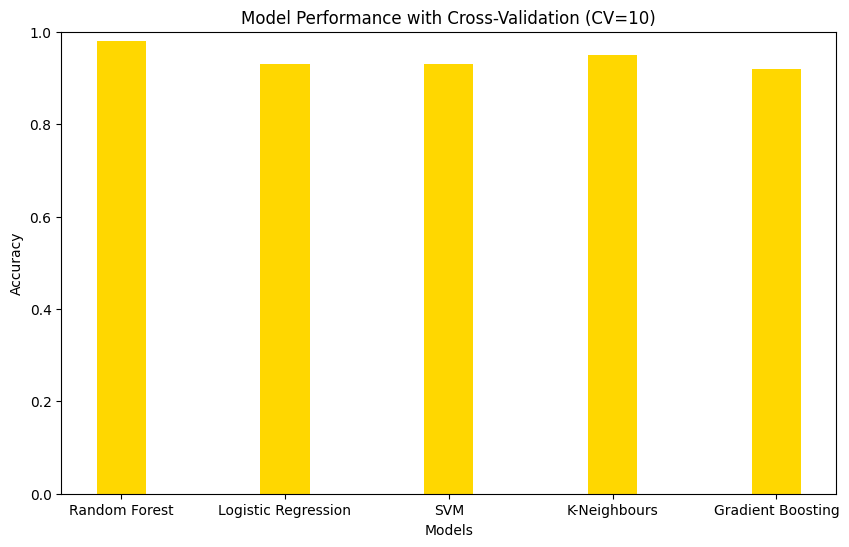

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Neighbours', 'Gradient Boosting']

# Performance accuracies
accuracies = {
    'Random Forest': [0.98],
    'Logistic Regression': [0.93],
    'SVM': [0.93],
    'K-Neighbours': [0.95],
    'Gradient Boosting': [0.92]
}

# Extracting accuracies and setting range
accuracy_values = [accuracy[0] for accuracy in accuracies.values()]
accuracy_range = np.arange(0.0, 1.1, 0.2)

# Bar chart configuration
bar_width = 0.3

# Using 'gold' for all bars
colors = ['gold'] * len(models)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(models, accuracy_values, bar_width, label='Accuracy', color=colors)

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance with Cross-Validation (CV=10)')
ax.set_ylim([0.0, 1.0])
ax.set_yticks(accuracy_range)

# Display the plot
plt.show()


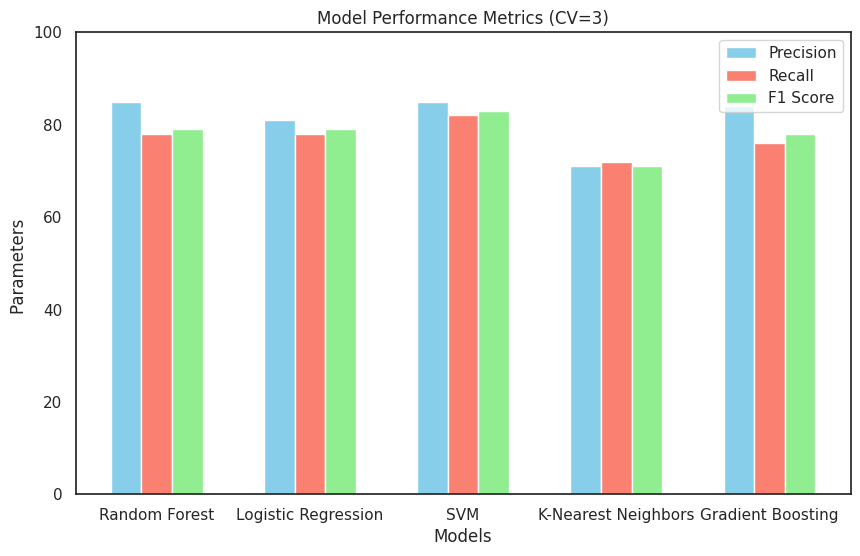

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import seaborn

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Gradient Boosting']

# Performance metrics values (scaled to the range of 0 to 100)
precision = [0.85, 0.81, 0.85, 0.71, 0.84]
recall = [0.78, 0.78, 0.82, 0.72, 0.76]
f1_score = [0.79, 0.79, 0.83, 0.71, 0.78]

# Scale the values to the range of 0 to 100
precision = np.array(precision) * 100
recall = np.array(recall) * 100
f1_score = np.array(f1_score) * 100

# Bar graph configuration
bar_width = 0.2
index = np.arange(len(models))

# Set seaborn style to remove background lines
sns.set(style='white')

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='skyblue')
bar2 = ax.bar(index, recall, bar_width, label='Recall', color='salmon')
bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Parameters ')
ax.set_title('Model Performance Metrics (CV=3)')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set the y-axis limit to 0-100
ax.legend()

# Display the plot
plt.show()




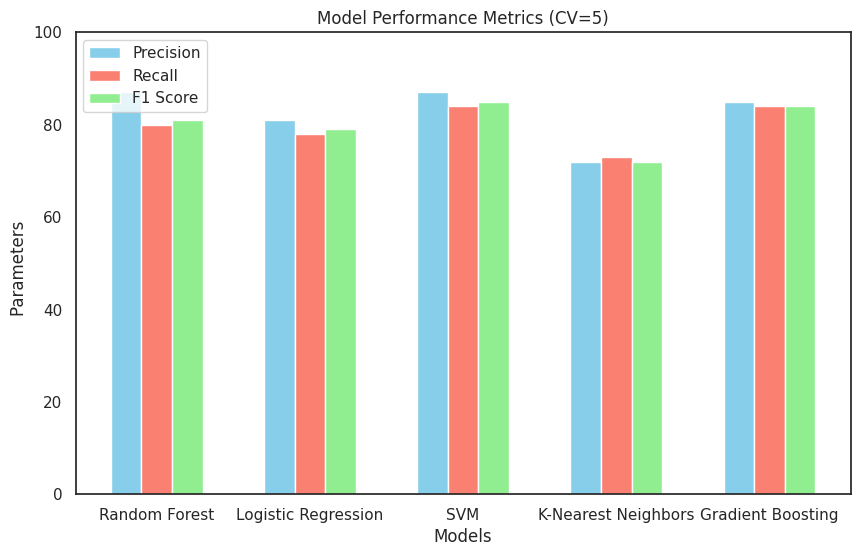

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import seaborn

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Gradient Boosting']

# Performance metrics values
precision = [0.87, 0.81, 0.87, 0.72, 0.85]
recall = [0.80, 0.78, 0.84, 0.73, 0.84]
f1_score = [0.81, 0.79, 0.85, 0.72, 0.84]

# Scale the values to the range of 0 to 100
precision = np.array(precision) * 100
recall = np.array(recall) * 100
f1_score = np.array(f1_score) * 100

# Bar graph configuration
bar_width = 0.2
index = np.arange(len(models))

# Set seaborn style to remove background lines
sns.set(style='white')

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='skyblue')
bar2 = ax.bar(index, recall, bar_width, label='Recall', color='salmon')
bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Parameters  ')
ax.set_title('Model Performance Metrics (CV=5)')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set the y-axis limit to 0-100 for precision, recall, and F1 Score
ax.legend()

# Display the plot
plt.show()



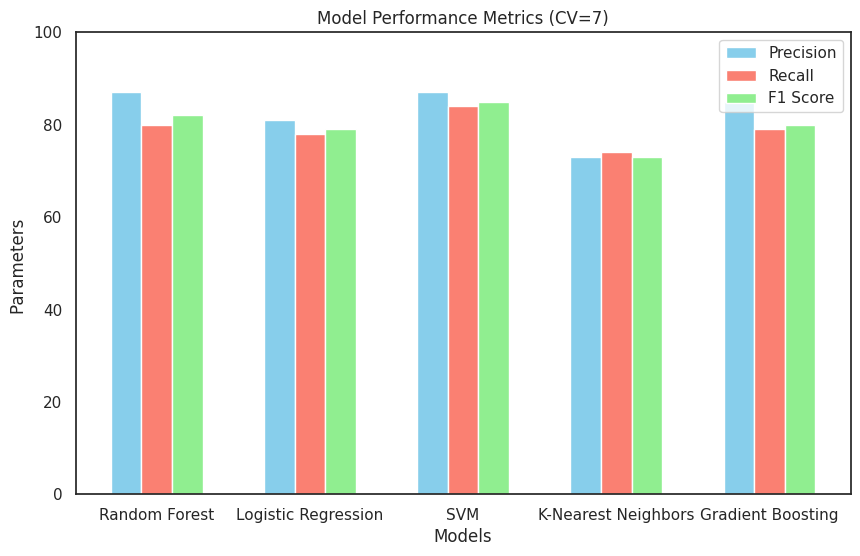

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Gradient Boosting']

# Performance metrics values
precision = [0.87, 0.81, 0.87, 0.73, 0.85]
recall = [0.80, 0.78, 0.84, 0.74, 0.79]
f1_score = [0.82, 0.79, 0.85, 0.73, 0.80]

# Scale the values to the range of 0 to 100
precision = np.array(precision) * 100
recall = np.array(recall) * 100
f1_score = np.array(f1_score) * 100

# Bar graph configuration
bar_width = 0.2
index = np.arange(len(models))

# Set seaborn style to remove background lines
sns.set(style='white')

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='skyblue')
bar2 = ax.bar(index, recall, bar_width, label='Recall', color='salmon')
bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Parameters ')
ax.set_title('Model Performance Metrics (CV=7)')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set the y-axis limit to 0-100 for precision, recall, and F1 Score
ax.legend()

# Display the plot
plt.show()


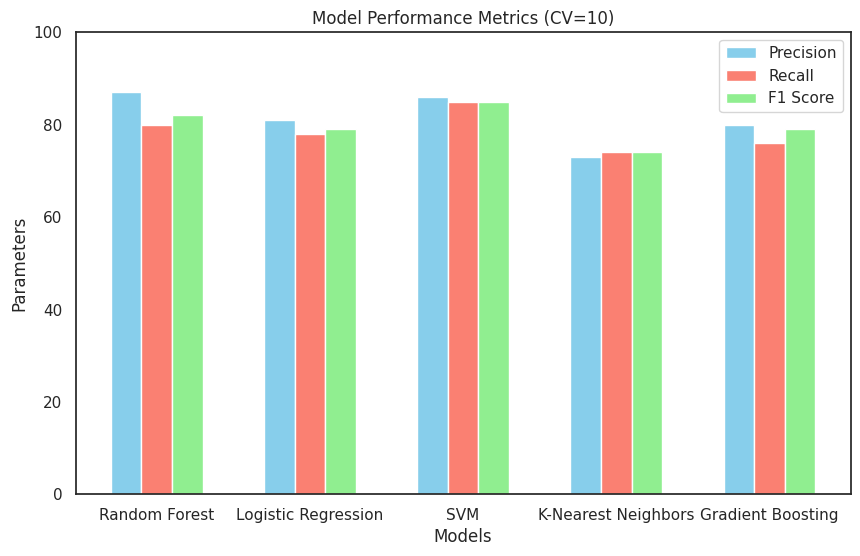

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Model names
models = ['Random Forest', 'Logistic Regression', 'SVM', 'K-Nearest Neighbors', 'Gradient Boosting']

# Performance metrics values
precision = [0.87, 0.81, 0.86, 0.73, 0.80]
recall = [0.80, 0.78, 0.85, 0.74, 0.76]
f1_score = [0.82, 0.79, 0.85, 0.74, 0.79]

# Scale the values to the range of 0 to 100
precision = np.array(precision) * 100
recall = np.array(recall) * 100
f1_score = np.array(f1_score) * 100

# Bar graph configuration
bar_width = 0.2
index = np.arange(len(models))

# Set seaborn style to remove background lines
sns.set(style='white')

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index - bar_width, precision, bar_width, label='Precision', color='skyblue')
bar2 = ax.bar(index, recall, bar_width, label='Recall', color='salmon')
bar3 = ax.bar(index + bar_width, f1_score, bar_width, label='F1 Score', color='lightgreen')

# Adding labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Parameters')
ax.set_title('Model Performance Metrics (CV=10)')
ax.set_xticks(index)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set the y-axis limit to 0-100 for precision, recall, and F1 Score
ax.legend()

# Display the plot
plt.show()
